<a href="https://colab.research.google.com/github/james-t-little/cnn_diss_repo/blob/main/code/parcel_boundary_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
from tqdm import tqdm
from collections import Counter

import keras
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GaussianNoise
from keras.layers import Conv2D, MaxPool2D, Input, concatenate, Conv2DTranspose
from keras.layers.convolutional import MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
SEED = random.randint(1, 100)

# used to mount the data repository to the google colab session
drive.mount('/content/drive')

# depending on the image imagerys size
IMG_SIZE = 256

# selects correct file location for the data
if IMG_SIZE == 256:
    path = '/content/drive/My Drive/parcel_boundaries_dataset/patched_data/256'
elif IMG_SIZE == 512:
    path = '/content/drive/My Drive/parcel_boundaries_dataset/patched_data/512'

# assigns a location path to both the image and mask of the segementation data
image_path = os.path.join(path,"image")
mask_path = os.path.join(path,"binary_mask")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# list individual image and mask paths for the dataset
image_paths = sorted([ os.path.join(image_path, fname) for fname in os.listdir(image_path) if fname.endswith(".png") ])
mask_paths = sorted([ os.path.join(mask_path, fname) for fname in os.listdir(mask_path) if fname.endswith(".png")])

# place paths into a dataframe for later computation
path_df = pd.DataFrame({'image':image_paths,'mask':mask_paths})

In [18]:
# split data into train, test and validation data
train, val_df = train_test_split(path_df,test_size=0.1, random_state=SEED)
train_df, test_df = train_test_split(train,test_size=0.11, random_state=SEED)

# number of items in train and validation set
size_train = train_df.shape[0]
size_val = val_df.shape[0]
size_test = test_df.shape[0]

In [19]:
# set hyperparameter values
EPOCHS = 65
BATCH_SIZE = 16

# generate dataset with assigned batch size and augmentation 
def create_data(generator, dataframe, colour_mode, batch_size, column):
    generator = generator.flow_from_dataframe(dataframe=dataframe, x_col = column, batch_size = batch_size, seed = SEED, class_mode = None, color_mode = colour_mode) 
    return generator

# zip image and mask together
def zip_pair(image,mask):
    for indv_image, indv_mask in zip(image,mask):
        yield indv_image, indv_mask

# instanciate image generator class with scaling and augmentation scheme for dataset
image_gen = ImageDataGenerator(rescale = 1/255, rotation_range = 0.2, width_shift_range = 0.1, height_shift_range = 0.1, zoom_range = 0.20, horizontal_flip = True)

mask_gen = ImageDataGenerator(rescale = 1/255, rotation_range = 0.2, width_shift_range = 0.1, height_shift_range = 0.1, zoom_range = 0.20, horizontal_flip = True)

# instanciate again with no augmentation for validation and test data
alt_image_gen = ImageDataGenerator(rescale=1/255)

alt_mask_gen = ImageDataGenerator(rescale=1/255)

# create image data
train_image = create_data(image_gen, train_df, 'rgb', BATCH_SIZE, "image")

val_image = create_data(alt_image_gen, val_df, 'rgb', BATCH_SIZE, "image")

test_image = create_data(alt_image_gen, test_df, 'rgb', BATCH_SIZE, "image")

# create mask data
train_mask = create_data(image_gen, train_df, 'grayscale', BATCH_SIZE, "mask")

val_mask = create_data(alt_mask_gen, val_df, 'grayscale', BATCH_SIZE, "mask")

test_mask= create_data(alt_mask_gen, test_df, 'grayscale', BATCH_SIZE, "mask")

# create train, test and validation inputs
train_data = zip_pair(train_image, train_mask)

val_data = zip_pair(val_image,val_mask)

test_data = zip_pair(test_image,val_mask)

Found 3114 validated image filenames.
Found 389 validated image filenames.
Found 385 validated image filenames.
Found 3114 validated image filenames.
Found 389 validated image filenames.
Found 385 validated image filenames.


In [22]:
# convolutional block used for both encoder and decoder
def convolutional_block(prev, filter_size, kernel):
        x = Conv2D(filter_size, kernel, activation='relu', kernel_initializer='he_normal', padding='same')(prev)
        x = Dropout(0.05)(x)
        x = Conv2D(filter_size, kernel, activation='relu', kernel_initializer='he_normal', padding='same')(x)
        return x

# u-net method
def u_net_seg_model(img_shape, n_classes, filter_start):

    # input layer with defined shape
    input_layer = Input(shape=img_shape)
    x = input_layer

    # number of filters defined at each U-Net layer
    filter_list = [filter_start, filter_start * 2, filter_start * 4, filter_start * 8]

    # create skip connection
    skip = []

    # iterate through each layer of the encoder block
    for filter_size in filter_list:
        x = convolutional_block(x, filter_size, (3,3))
        skip.append(x)
        x = MaxPooling2D((2, 2))(x)

    # reverse the skip connection list
    skip = list(reversed(skip))
    
    # bridge connection
    x = convolutional_block(x, (filter_start * 8), (3,3))

    # iterate up through each layer of the decoder block
    for count,filter_size in enumerate(reversed(filter_list)):
        x = Conv2DTranspose(filter_size, (2, 2), strides=(2, 2), padding='same')(x)
        x = concatenate([x, skip[count]])
        convolutional_block(x, filter_size, (3,3))

    # select output activation function depend on whether the output is binary (sigmoid) or multi-class (softmax)
    if n_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    # output layer
    output_layer = Conv2D(n_classes, kernel_size=(1, 1), activation=activation)(x)

    return Model(inputs=input_layer, outputs=output_layer)

# create model with selected parameters
model = u_net_seg_model((IMG_SIZE, IMG_SIZE, 3), n_classes = 1, filter_start = 32)

In [23]:
# compile model with optimiser, loss and metrics 
# loss metric needed to reflect the output of the model data e.g. binary - binary crossentropy & multi_class - categorical crossentropy 
model.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])

# callback saving the model each time it achieves a better loss value

callbacks = [tf.keras.callbacks.ModelCheckpoint(("/content/drive/MyDrive/"+'boundary_model_e100_bs4.h5'), verbose = 1, save_best_only=True, save_weights_only=True)]

# calculate number of steps per epoch and validation steps
train_step = size_train / BATCH_SIZE
val_step = size_val / BATCH_SIZE

# run the U-Net model
trained_model = model.fit(train_data, steps_per_epoch = train_step, epochs= EPOCHS, validation_data = val_data, validation_steps = val_step, callbacks = callbacks)


Epoch 1/65
195/194 [==============================] - ETA: 0s - loss: 0.4062 - accuracy: 0.8289
Epoch 1: val_loss improved from inf to 0.37996, saving model to /content/drive/MyDrive/boundary_model_e100_bs4.h5
194/194 [==============================] - 72s 366ms/step - loss: 0.4062 - accuracy: 0.8289 - val_loss: 0.3800 - val_accuracy: 0.8592
Epoch 2/65
195/194 [==============================] - ETA: 0s - loss: 0.3659 - accuracy: 0.8281
Epoch 2: val_loss improved from 0.37996 to 0.34261, saving model to /content/drive/MyDrive/boundary_model_e100_bs4.h5
194/194 [==============================] - 71s 368ms/step - loss: 0.3659 - accuracy: 0.8281 - val_loss: 0.3426 - val_accuracy: 0.8628
Epoch 3/65
195/194 [==============================] - ETA: 0s - loss: 0.3475 - accuracy: 0.8310
Epoch 3: val_loss improved from 0.34261 to 0.32647, saving model to /content/drive/MyDrive/boundary_model_e100_bs4.h5
194/194 [==============================] - 71s 367ms/step - loss: 0.3475 - accuracy: 0.8310 - 

In [24]:
# model metrics during training
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']
accuracy = trained_model.history['accuracy']
val_accuracy = trained_model.history['val_accuracy']

# function to plot metrics
def plot_training_data(graph_name, train_metric, val_metric):
    plt.figure(figsize = (8,8))
    plt.plot(train_metric, label = "Train")
    plt.plot(val_metric, label = "Validation")
    plt.title(graph_name)
    plt.legend(loc="upper left")
    plt.show()


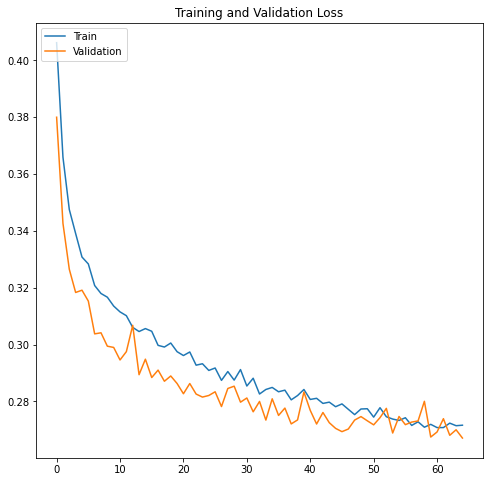

In [25]:
# loss graph
plot_training_data("Training and Validation Loss", loss, val_loss)

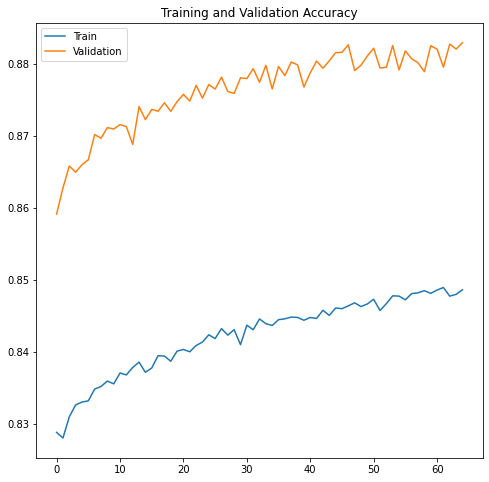

In [26]:
# accuracy graph
plot_training_data("Training and Validation Accuracy", accuracy, val_accuracy)

In [27]:
# reset index of test dataframe
test_df = test_df.reset_index()

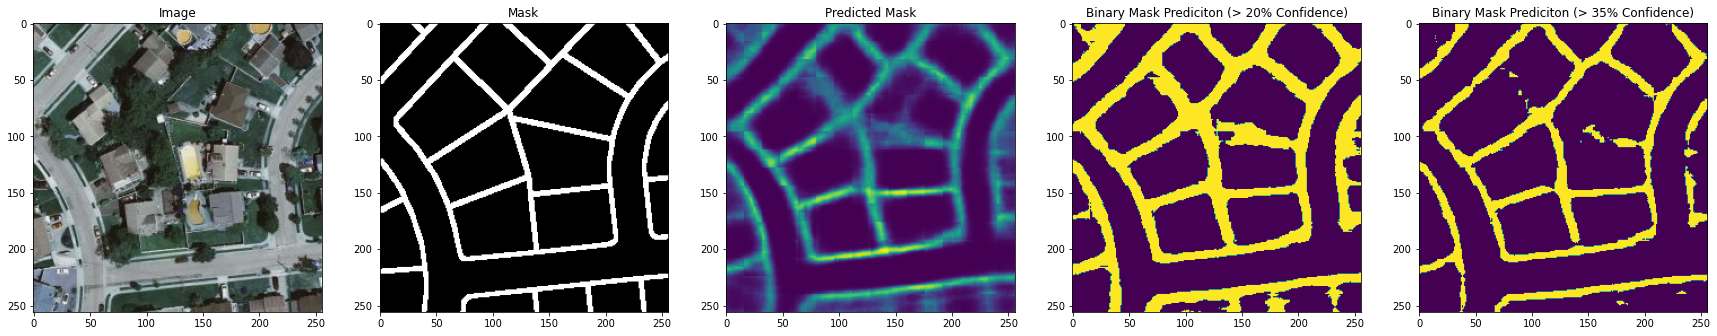

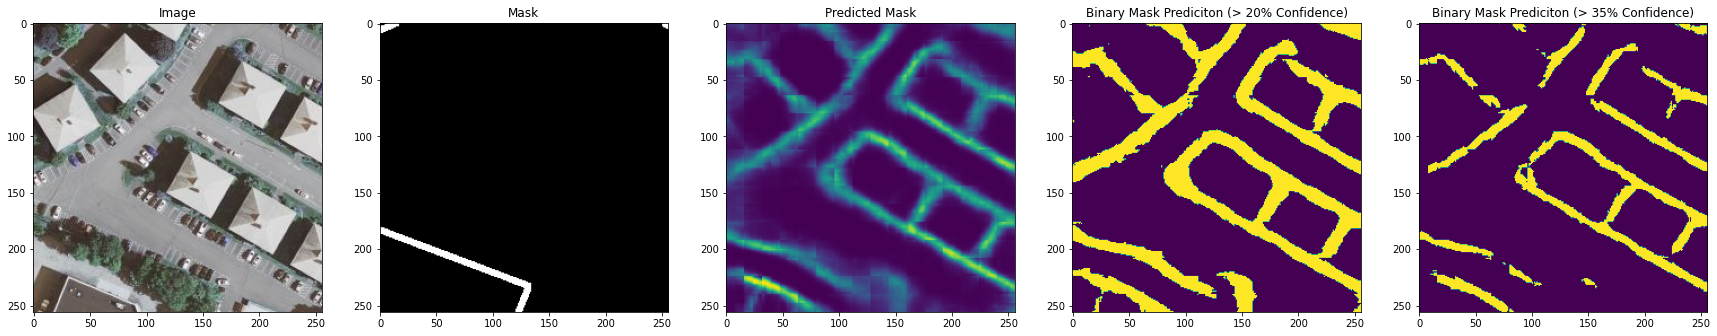

In [29]:
# method to create a prediction mask based on a input image and its ground truth mask
def predict_img(img_path,mask_path):
    image = cv2.imread(img_path)
    mask = cv2.imread(mask_path)
    image = image/255
    image = image[np.newaxis,:]
    pred_mask = model.predict(image) 
    return image, mask, pred_mask

# graph the prediction of an image, ground truth mask and predicted mask
# a classification uses binary crossentropy loss, a confidence probability it assigned to each pixel classification
def plot_predictions(img,mask,pred_mask):
    plt.figure(figsize=(30,30))
    plt.subplot(1,5,1)
    plt.imshow(np.squeeze(img))
    plt.title('Image')
    plt.subplot(1,5,2)
    plt.imshow(np.squeeze(mask))
    plt.title('Mask')
    plt.subplot(1,5,3)
    plt.imshow(np.squeeze(pred_mask))
    plt.title('Predicted Mask')
    plt.subplot(1,5,4)
    plt.imshow(np.squeeze(pred_mask) > 0.2)
    plt.title('Binary Mask Prediciton (> 20% Confidence)')
    plt.subplot(1,5,5)
    plt.imshow(np.squeeze(pred_mask) > 0.35)
    plt.title('Binary Mask Prediciton (> 35% Confidence)')
    plt.show()

# select random images from test dataset to create a segmentation using the U-Net
num_pred = 2
for num in range(num_pred):
    index = random.randint(1, size_test)
    img_path = test_df['image'][index]
    mask_path = test_df['mask'][index]
    img,mask,pred_mask =  predict_img(img_path,mask_path)
    plot_predictions(img,mask,pred_mask)